In [1]:
1+1

depwarn at ./deprecated.jl in depwarn at ./deprecated.jl:64
:64
 in super at ./deprecated.jl in readbytes at ./deprecated.jl:50
:30
 in flush at /Users/imolk/.julia/v0.5/IJulia/src/stdio.jl in watch_stream at /Users/imolk/.julia/v0.5/IJulia/src/stdio.jl:186
: [inlined code] from 48/Users/imolk/.julia/v0.5/IJulia/src/stdio.jl
:172
 in execute_request_0x535c5df2 at /Users/imolk/.julia/v0.5/IJulia/src/execute_request.jl:204
 in  [inlined code] from anonymous./dict.jl at ./task.jl:733
 in eventloop at /Users/imolk/.julia/v0.5/IJulia/src/IJulia.jl:142
:435
while loading /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl, in expression starting on line 31 in 
anonymous at ./task.jl:435
while loading /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl, in expression starting on line 31


2

In [2]:
using Mamba

    write(GZip.GZipStream, Array{#T<:Any, N<:Any}) at /Users/imolk/.julia/v0.5/GZip/src/GZip.jl:456
is ambiguous with: 
    write(Base.IO, Array{UInt8, N<:Any}) at io.jl:154.
To fix, define 
    write(GZip.GZipStream, Array{UInt8, N<:Any})
before the new definition.


In [3]:
using GraphViz

In [4]:
model = Model(
    y = Stochastic(1, 
        (mu, s2) -> MvNormal(mu, sqrt(s2)),
        false
    ),
    mu = Logical(1, 
        (xmat, beta) -> xmat * beta,
        false
    ),    
    beta = Stochastic(1,
        () -> MvNormal(2, sqrt(1000)),
        true
    ),
    s2 = Stochastic(
        () -> InverseGamma(0.001, 0.001),
        true
    )
)

Object of type "Mamba.Model"
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element Mamba.ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s2:
A monitored node of type "Mamba.ScalarStochastic"
NaN
-------------------------------------------------------------------------------
beta:
A monitored node of type "0-element Mamba.ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
mu:
An unmonitored node of type "0-element Mamba.ArrayLogical{1}"
Float64[]


In [5]:
scheme1 = [NUTS(:beta), 
           Slice(:s2, 3.0),
          ]
scheme2 = [NUTS([:beta, :s2])]

 in depwarn at ./deprecated.jl:64
 in tty_size at ./deprecated.jl:915
 in showf at /Users/imolk/.julia/v0.5/Mamba/src/model/model.jl:216
 [inlined code] from /Users/imolk/.julia/v0.5/Mamba/src/model/model.jl:207
 in showcompact at ./show.jl:1437
 in writemime at ./replutil.jl:4
 [inlined code] from ./expr.jl:8
 in writemime at ./multimedia.jl:43
 in sprint at ./strings/io.jl:38
 in display_dict at /Users/imolk/.julia/v0.5/IJulia/src/execute_request.jl:26
 in execute_request_0x535c5df2 at /Users/imolk/.julia/v0.5/IJulia/src/execute_request.jl:213
 [inlined code] from ./dict.jl:733
 in eventloop at /Users/imolk/.julia/v0.5/IJulia/src/IJulia.jl:142
 in anonymous at ./task.jl:435
while loading /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl, in expression starting on line 31


1-element Array{Mamba.Sampler{Mamba.NUTSTune},1}:
 An object of type "Mamba.Sampler{Mamba.NUTSTune}"
Sampling Block Nodes:
[:beta,:s2]

AST(:($(Expr(:lambda, Any[:(model::Model),:(block::Integer)], Any[Any[Any[:model,:Any,18],Any[:block,:Any,18],Any[:f,:Any,18]],Any[],0,Any[]], :(begin 
        model = (top(typeassert))(model,Mamba.Model)
        block = (top(typeassert))(block,Mamba.Integer)
        f = (anonymous function)
        return f(model,block)
    end)))))


In [6]:
## User-Defined Samplers

Gibbs_beta = Sampler([:beta],
  (beta, s2, xmat, y) ->
    begin
      beta_mean = mean(beta.distr)
      beta_invcov = invcov(beta.distr)
      Sigma = inv(xmat' * xmat / s2 + beta_invcov)
      mu = Sigma * (xmat' * y / s2 + beta_invcov * beta_mean)
      rand(MvNormal(mu, Sigma))
    end
)

Gibbs_s2 = Sampler([:s2],
  (mu, s2, y) ->
    begin
      a = length(y) / 2.0 + shape(s2.distr)
      b = sumabs2(y - mu) / 2.0 + scale(s2.distr)
      rand(InverseGamma(a, b))
    end
)

## User-Defined Sampling Scheme
scheme3 = [Gibbs_beta, Gibbs_s2]

2-element Array{Mamba.Sampler{Dict{Any,Any}},1}:
 An object of type "Mamba.Sampler{Dict{Any,Any}}"
Sampling Block Nodes:
[:beta]

AST(:($(Expr(:lambda, Any[:(model::Model),:(block::Integer)], Any[Any[Any[:model,:Any,18],Any[:block,:Any,18],Any[:f,:Any,18]],Any[],0,Any[]], :(begin 
        model = (top(typeassert))(model,Mamba.Model)
        block = (top(typeassert))(block,Mamba.Integer)
        f = (anonymous function)
        return f((Mamba.getindex)(model,:beta),(Mamba.getindex)(model,:s2),(Mamba.getindex)(model,:xmat),(Mamba.getindex)(model,:y))
    end)))))

 An object of type "Mamba.Sampler{Dict{Any,Any}}"
Sampling Block Nodes:
[:s2]

AST(:($(Expr(:lambda, Any[:(model::Model),:(block::Integer)], Any[Any[Any[:model,:Any,18],Any[:block,:Any,18],Any[:f,:Any,18]],Any[],0,Any[]], :(begin 
        model = (top(typeassert))(model,Mamba.Model)
        block = (top(typeassert))(block,Mamba.Integer)
        f = (anonymous function)
        return f((Mamba.getindex)(model,:mu),(Mamba.getind

In [7]:
setsamplers!(model, scheme1)

Object of type "Mamba.Model"
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element Mamba.ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s2:
A monitored node of type "Mamba.ScalarStochastic"
NaN
-------------------------------------------------------------------------------
beta:
A monitored node of type "0-element Mamba.ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
mu:
An unmonitored node of type "0-element Mamba.ArrayLogical{1}"
Float64[]


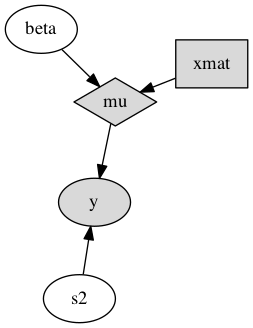

 in depwarn at ./deprecated.jl:64
 in write at ./deprecated.jl:50
 in write_to_stream_callback at /Users/imolk/.julia/v0.5/Cairo/src/Cairo.jl:86
 [inlined code] from /Users/imolk/.julia/v0.5/Cairo/src/Cairo.jl:306
 in writemime at /Users/imolk/.julia/v0.5/Cairo/src/Cairo.jl:315
 in writemime at /Users/imolk/.julia/v0.5/GraphViz/src/GraphViz.jl:590
 in base64encode at ./base64.jl:159
 in display_dict at /Users/imolk/.julia/v0.5/IJulia/src/execute_request.jl:32
 [inlined code] from ./operators.jl:433
 in display at /Users/imolk/.julia/v0.5/IJulia/src/inline.jl:35
 [inlined code] from ./multimedia.jl:151
 in display at ./multimedia.jl:163
 [inlined code] from ./essentials.jl:118
 in include_string at ./loading.jl:371
 in execute_request_0x535c5df2 at /Users/imolk/.julia/v0.5/IJulia/src/execute_request.jl:182
 [inlined code] from ./dict.jl:733
 in eventloop at /Users/imolk/.julia/v0.5/IJulia/src/IJulia.jl:142
 in anonymous at ./task.jl:435
while loading In[8], in expression starting on lin

In [8]:
display(Graph(graph2dot(model)))

In [9]:
line = Dict{Symbol, Any}(
  :x => [1, 2, 3, 4, 5],
  :y => [1, 3, 3, 3, 5]
)
line[:xmat] = [ones(5) line[:x]]

5x2 Array{Float64,2}:
 1.0  1.0
 1.0  2.0
 1.0  3.0
 1.0  4.0
 1.0  5.0

In [10]:
## Initial Values
inits = [
  Dict{Symbol, Any}(
    :y => line[:y],
    :beta => rand(Normal(0, 1), 2),
    :s2 => rand(Gamma(1, 1))
  )
for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict{Symbol,Any}(:y=>[1,3,3,3,5],:s2=>1.67022,:beta=>[-0.654841,-0.4796])  
 Dict{Symbol,Any}(:y=>[1,3,3,3,5],:s2=>0.304649,:beta=>[-0.802957,0.716819])
 Dict{Symbol,Any}(:y=>[1,3,3,3,5],:s2=>2.36483,:beta=>[1.42775,0.782308])   

In [11]:
## MCMC Simulations

setsamplers!(model, scheme1)
sim1 = mcmc(model, line, inits, 10000, burnin=250, thin=2, chains=3)

setsamplers!(model, scheme2)
sim2 = mcmc(model, line, inits, 10000, burnin=250, thin=2, chains=3)

setsamplers!(model, scheme3)
sim3 = mcmc(model, line, inits, 10000, burnin=250, thin=2, chains=3)

MCMC Simulation of 10000 Iterations x 3 Chains...

Chain 1:   0% [0:26:26 of 0:26:28 remaining]
Chain 1:  10% [0:00:22 of 0:00:24 remaining]
Chain 1:  20% [0:00:12 of 0:00:14 remaining]
Chain 1:  30% [0:00:08 of 0:00:11 remaining]
Chain 1:  40% [0:00:06 of 0:00:10 remaining]
Chain 1:  50% [0:00:04 of 0:00:09 remaining]
Chain 1:  60% [0:00:03 of 0:00:08 remaining]
Chain 1:  70% [0:00:02 of 0:00:08 remaining]
Chain 1:  80% [0:00:01 of 0:00:07 remaining]
Chain 1:  90% [0:00:01 of 0:00:07 remaining]
Chain 1: 100% [0:00:00 of 0:00:07 remaining]

Chain 2:   0% [0:00:04 of 0:00:04 remaining]
Chain 2:  10% [0:00:05 of 0:00:05 remaining]
Chain 2:  20% [0:00:04 of 0:00:05 remaining]
Chain 2:  30% [0:00:04 of 0:00:05 remaining]
Chain 2:  40% [0:00:03 of 0:00:05 remaining]
Chain 2:  50% [0:00:03 of 0:00:05 remaining]
Chain 2:  60% [0:00:02 of 0:00:05 remaining]
Chain 2:  70% [0:00:02 of 0:00:05 remaining]
Chain 2:  80% [0:00:01 of 0:00:05 remaining]
Chain 2:  90% [0:00:01 of 0:00:05 remaining]
Cha

Object of type "Mamba.ModelChains"

Iterations = 252:10000
Thinning interval = 2
Chains = 1,2,3
Samples per chain = 4875

4875x3x3 Array{Float64,3}:
[:, :, 1] =
 -0.348106  0.931831  1.24677 
  0.802503  0.752165  1.16277 
  0.652764  0.73456   1.06383 
  1.12396   0.682054  0.308918
 -0.272704  1.0961    0.342859
  0.522043  0.787195  0.357727
 -0.183754  0.945715  0.687075
  0.475237  0.71246   0.417205
 -0.309272  1.01978   0.3001  
  1.15513   0.958248  4.22057 
  1.19152   0.442014  0.668349
  1.4888    0.687702  0.241562
  0.287716  0.890885  0.658561
  ⋮                           
  0.968908  0.668218  0.275498
  1.7761    0.341747  0.313992
  1.35545   0.519624  0.544147
  0.7246    0.749539  0.224746
  0.616212  0.796981  0.278425
  1.93647   0.245366  1.18509 
  0.238555  0.966525  0.432328
  1.02422   0.831831  0.670722
  1.72706   0.565504  2.49643 
  0.393177  0.814973  2.13836 
  0.358701  0.642274  0.793323
  2.79309   0.586127  2.84247 

[:, :, 2] =
  1.27749   0.547418

In [12]:
gelmandiag(sim1, mpsrf=true, transform=true)

              PSRF 97.5%
     beta[1] 1.016 1.016
     beta[2] 1.015 1.015
          s2 1.016 1.033
Multivariate 1.012   NaN



In [13]:
gelmandiag(sim2, mpsrf=true, transform=true)

              PSRF 97.5%
     beta[1] 1.007 1.008
     beta[2] 1.008 1.010
          s2 1.003 1.011
Multivariate 1.006   NaN



In [14]:
gelmandiag(sim3, mpsrf=true, transform=true)

              PSRF 97.5%
     beta[1] 1.001 1.001
     beta[2] 1.001 1.001
          s2 1.001 1.002
Multivariate 1.001   NaN

